# Spacecraft Dynamics Capstone Project.

### Attitude Dynamics and Control of a Nano-Satellite Orbiting Mars.

### Mission Brief:

"*A nano-satellite in on a circular low Mars orbit $(LMO)$ mars to observe the non-sunlit Mars surface.
A second satellite, the mother spacecraft, is on a circular geosynchronous mars orbit $(GMO)$. The
nano-satellite is to either point a sensor at the surface when in science mode, point the solar panels in
the sun direction when in power mode, and point the communication dish at the mothercraft when in
communication mode For simplicity, it is assumed that both the nano and the mothercraft are in simple two-body circular
orbits. The nano-satellite’s orbit is characterized by an altitude of $h = 400 km$ (i.e., the orbit radius is
$r_{LMO} = R♂+h$ where $R♂ = 3396.19 km$), and the (3-1-3) Euler angle set right ascension $Ω$, inclination
angle $i$ and the true latitude angle $θ$ as illustrated in Figure 1. Let the Mars gravity constant be given by
$µ = 42828.3 km^3
/s^2$
.The constant orbit rate is then given by $\dot{θ}_{LMO} = \sqrt{µ/r3} = 0.000884797 rad/sec$.
Mars has a rotational period of 1 day and 37 minutes. Thus the geosynchronous mothercraft must
have the same orbit period. This leads to a constant orbit radius of $r_{GMO} = 20424.2 km$. As the
mothercraft orbit is in the equatorial plane, it has a zero inclination angle. The GMO orbit rate is
$GMO = 0.0000709003 rad/s$. Because both the LMO and GMO orbits are circular, their angular rates
$\dot{θ}_{GMO} = \sqrt{µ/r3}$ are constant.
These two circular orbits can easily be described in the so-called Hill frame (denoted H). Figure 1
shows the orientation of the Hill frame with respect to the inertial frame (denoted N ). In the Hill frame,
$\hat{i}_r$ points to the spacecraft, $\hat{i}_h$ is the direction of the angular momentum vector, and $\hat{i}_\theta$ = $\hat{i}_h \times \hat{i}_r$. It is
important to note that the Hill frame is given through the (3-1-3) Euler angle set $(Ω, i, θ)$.
In order to make this a realistic simulation, the LMO spacecraft is equipped with an antenna to
communicate with the mothercraft (aligned with $-\hat{b}_1$), a sensor to observe to observe Mars (aligned
with $+\hat{b}_1$), and solar panels for power (panel normal is along $+\hat{b}_3$). Each of these devices are located
on a different face of the spacecraft. Figure 3 shows the layout of the LMO spacecraft. In the following
sections, you will derive the expressions of the attitude reference that the satellite must track, as well
as the associated attitude error. Once these quantities are know and related to the spacecraft’s current
attitude and position, you will eventually implement a control law that drives the spacecraft attitude B
towards its reference R for the two mission phases.*"

### Initial Conditions and Parameters:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy import * 
import math

In [3]:
#Mars Characteristics:
R_Mars = 3396.19 #km
mu_Mars = 42828.3 #km/s

#Circular Low Mars Orbit (LMO): Nano-Satellite.
h = 400 #km
R_LMO = R_Mars + h #km
Theta_dot_LMO = np.sqrt(mu_Mars/R_LMO**3) #rad/s
LMO_angles = np.array([np.deg2rad(i) for i in [20, 30, 60]]).T #rad
dLMO_angles = np.array([0, 0, Theta_dot_LMO]).T #rad/s


#Geosynchronous Mars Orbit (GMO): Mother Spacecraft.
R_GMO = 20424.2 #km
Theta_dot_GMO = np.sqrt(mu_Mars/R_GMO**3) #rad/s
GMO_angles = np.array([np.deg2rad(i) for i in [0, 0, 250]]) #rad
dGMO_angles = np.array([0, 0, Theta_dot_GMO]).T #rad/s


#Nano Satellite Initial attitude states:
Sigma_BN = np.array([0.3, -0.4, 0.5]).T
Omega_BN = np.array([np.deg2rad(i) for i in [1.00, 1.75, -2.20]]).T

#Rigid LMO Intertia tensor:
I = np.array([[10, 0,   0],
              [ 0, 5,   0],
              [ 0, 0, 7.5]]) #kg m^2

### Utility functions required to complete tasks:

#### 1) Euler angle to DCM converison function.
In this particular context, we are only interested in the "3-1-3" confoguration.

In [4]:
def YRY_DCM(angles):
    
    a_1, a_2, a_3 = angles
    
    s1 = np.sin(a_1); s2 = np.sin(a_2); s3 = np.sin(a_3)
    c1 = np.cos(a_1); c2 = np.cos(a_2); c3 = np.cos(a_3)

    DCM = np.array([[ c3*c1 - s3*c2*s1,  c3*s1 + s3*c2*c1, s3*s2],
                    [-s3*c1 - c3*c2*s1, -s3*s1 + c3*c2*c1, c3*s2],
                    [            s2*s1,            -s2*c1,    c2]])

    
    return DCM

#### 2) DCM to "3-1-3" Euler angle conversion function.

In [5]:
"""Explicitly converts the DCM into the 3-1-3 Euler angle set (Ω, i, ω)"""

def DCM_to_EulerAngle(DCM):
    
    C31 = DCM[2][0]; C32 = DCM[2][1]; C33 = DCM[2][2]; C13 = DCM[0][2]; C23 = DCM[1][2]
    
    Omega = atan(C31/-C32)
    i = acos(C33)
    omega = atan(C13/C23)
    
    return np.array([Omega, i, omega])

#### 3) Skew symmetric matix function.

In [6]:
"""Skew Symmetric matrix generator for cross product operations."""

def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])

#### 4) Quaternion attitude set to MRP attitude set conversion function.

In [7]:
"""
Converts 1x4 Quaternion attitude desc to 1x3 MRP attitude desc. The condition upon 
which |MRP|^2 > 1, the shadow set should be returned. 
"""

def Quaternion_to_MRP(q):
    sig = [q[i]/(1+q[0]) for i in range(1,len(q))]
    sig_shadow = [-q[i]/(1-q[0]) for i in range(1,len(q))]
    return sig, sig_shadow

#### 5) MRP to DCM conversion function.

In [8]:
def MRP_to_DCM(a):
    a_norm = sqrt(a[0]**2 + a[1]**2 + a[2]**2)#np.linalg.norm(a)
    return np.eye(3) + (1/(1 + a_norm**2))**2 * ((8 * np.dot(skew(a),skew(a))) - 4 * (1 - a_norm**2) * skew(a))

#### 6) DCM to MRP conversion function.

In [9]:
def DCM_to_MRP(C):
    z = sqrt(C.trace() + 1)
    return (1/(z*(z+2))) * np.array([C[1][2] - C[2][1],
                                     C[2][0] - C[0][2],
                                     C[0][1] - C[1][0]])

In [10]:
def MRP_Shadow(sig):
    N = np.dot(sig,sig)**2 #(sqrt(sig[0]**2 + sig[1]**2 + sig[2]**2))**2
    return np.array([-i/N for i in sig])

### TASK 1: Orbit Simulation.

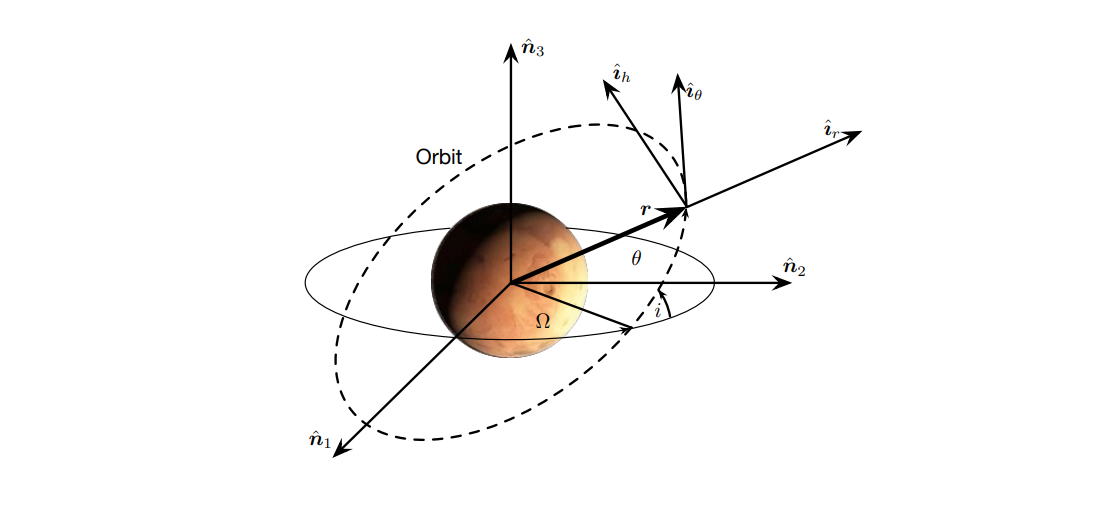

**Figure. 1.** Illustration of the inertial frame $N: \{\hat{n}_1, \hat{n}_2, \hat{n}_3 \}$ and hill frame $N: \{\hat{i}_r, \hat{i}_\theta, \hat{i}_h \}$

Assume the general orbit frame $O : \{i_r, i_{\theta}, i_h\}$ as illustrated in Figure 1. This allows the position vector on a circular orbit to be written as $r = r\hat{i}_r$ where r is here a constant radius. Your tasks are:

**1.1.** Derive the inertial spacecraft velocity vector $\dot{r}$. Note that for a circular orbit $\dot{\theta}$ is constant.

Using the transport theorem: $$\dot{r} = {}^N\frac{d}{dt}r = \hat{i}_r{}^B\frac{d}{dt}r + \dot{\theta}\hat{i}_h \times r\hat{i}_r$$

$$\dot{r} = \hat{i}_r\dot{r} + r\dot{\theta}(\hat{i}_h \times \hat{i}_r)$$

$$\dot{r} = \hat{i}_r\dot{r} + r\dot{\theta}\hat{i}_\theta$$

Rewriting $\hat{i}_r = \hat{r}$ and $\hat{i}_\theta = \hat{\theta}$, where $\hat{r}$ and $\hat{\theta}$ are colinear to  $\hat{i}_r$ and  $\hat{i}_\theta$ respectively.

Considering the orbit is ideally circular, the first term goes to zero, and $\dot{\theta} = const$ therefore:

$$\dot{r} = r\dot{\theta}\hat{\theta}$$

**1.2.** Write a function whose inputs are the radius $r$ and the (3-1-3) Euler angles $(\Omega, i, \theta)$ and the outputs are the inertial position vector ${}^Nr$ and velocity ${}^N\dot{r}$ of the associated circular orbit.

In [11]:
def Inertial_Position_Velocity_Vec(angles, d_angles, r, t): #sequence = "3-1-3"
    
    #Updating the Euler angles at time "t".
    angles_t = angles + d_angles * t
    
    mu_Mars = 42828.3 #km/s
    Br_dot = np.array([0, r*np.sqrt(mu_Mars/r**3), 0])
    
    #Inertial Positional Vector:
    Nr = np.dot(YRY_DCM(angles_t).T, np.array([r, 0, 0]))
    #Inertial Velocity Vector:
    Nr_dot = np.dot(YRY_DCM(angles_t).T, Br_dot) 
    
    return Nr, Nr_dot

**1.3.** The inertial position ${}^Nr$ and velocity ${}^N\dot{r}$ vector values for the **LMO** spacecraft at $t = 450s$

In [31]:
Task1_LMO = Inertial_Position_Velocity_Vec(LMO_angles, dLMO_angles, R_LMO, 450)

print("Inertial Position Vector at t = 450s")
print(Task1_LMO[0],"\n")

print("Inertial Velocity Vector at t = 450s")
print(Task1_LMO[1])

Inertial Position Vector at t = 450s
[-669.28508994 3227.49826592 1883.18106617] 

Inertial Velocity Vector at t = 450s
[-3.2559645  -0.79778654  0.21011585]


**1.4.** The inertial position ${}^Nr$ and velocity ${}^N\dot{r}$ vector values for the **GMO** spacecraft at $t = 1150s$

In [15]:
Task1_GMO = Inertial_Position_Velocity_Vec(GMO_angles, dGMO_angles, R_GMO, 1150)

print("Inertial Position Vector at t = 1150s")
print(Task1_GMO[0],"\n")

print("Inertial Velocity Vector at t = 1150s")
print(Task1_GMO[1])

Inertial Position Vector at t = 1150s
[-5399.15037424224 -19697.6425207769 0] 

Inertial Velocity Vector at t = 1150s
[1.39656800319355 -0.382801172736470 0]


### TASK 2: Orbit Frame Orientation.

Let Hill frame $H : \{i_r, i_{\theta}, i_h\}$ be the orbit frame of the LMO satellite. These base vectors are generally defined as:

$$i_r = \frac{r_{LM}}{|r_{LM}|}, \;   i_{\theta} = i_h \times i_r, \;   i_h = \frac{r_{LM} \times \dot{r}_{LMO}}{|r_{LM} \times \dot{r}_{LMO}|}$$

**2.1.** Write a function whose input is simply time t, and the output is the DCM $[HN(t)]$.

In [1060]:
"""[HN] maps from the inertial basis N to the LMO basis H"""

def HN(t):

    #Inertial position and velocity vectors (LMO):
    N_r_LMO, N_r_dot_LMO = Inertial_Position_Velocity_Vec(LMO_angles, dLMO_angles, R_LMO, t)
    
    #Computing the N_r vector Norm, N_r and N_r_dot cross product vector norm:
    N_r_norm = sqrt(N_r_LMO[0]**2 + N_r_LMO[1]**2 + N_r_LMO[2]**2)
    N_r_r_dot_cross = np.cross(N_r_LMO, N_r_dot_LMO)
    N_r_r_dot_norm = sqrt(N_r_r_dot_cross[0]**2 + N_r_r_dot_cross[1]**2 + N_r_r_dot_cross[2]**2)
    
    #Hill Frame Base vectors:
    i_r = N_r_LMO/N_r_norm
    i_h = N_r_r_dot_cross/N_r_r_dot_norm
    i_theta = np.cross(i_h, i_r)
    
    return np.array([i_r, i_theta, i_h])

**2.2.** Validate the operation of this function by computing $[HN(t=300s)]$

In [17]:
print(HN(300))

[[-0.0464774027261400 0.874147924476087 0.483430715997630]
 [-0.984172447503843 -0.122922132849527 0.127650863021049]
 [0.171010071662834 -0.469846310392954 0.866025403784439]]


### TASK 3: Sun-Pointing Reference Frame Orientation.

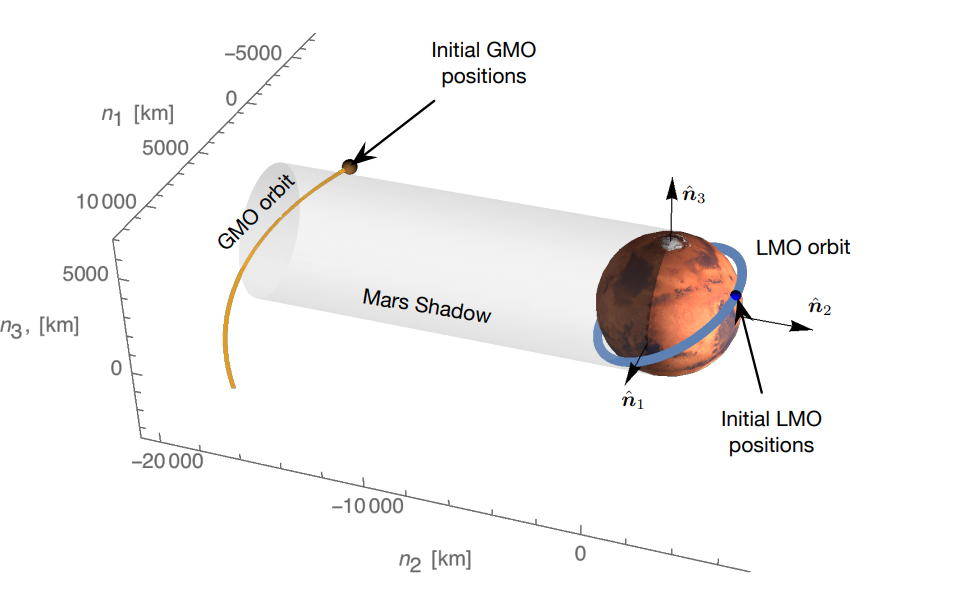

**Figure. 2.** Mission Orbit Scenario illustration.

To point the spacecraft solar panels axis $\hat{b}_3$ at the sun, the reference frame $R_s$ must be chosen such that $\hat{r}_3$ axis points in the sun direction ($\hat{n}_2$ in this scenario). Further, assume the first axis $\hat{r}_1$ points in
the $-\hat{n}_1$ direction. Your tasks are:

**3.1.** Determine an analytic expressions for the sun pointing reference frame $R_s$ by defining the DCM $[R_sN]$

$$\{\hat{r}\} = [R_sN]\{\hat{n}\}$$

$$ \hat{r}_1 = \{\hat{n}\}[cos(\pi), cos(\frac{\pi}{2}), cos(\frac{\pi}{2})] = \{\hat{n}\}[-1, 0, 0] = -\hat{n}_1 $$

$$ \hat{r}_2 = \{\hat{n}\}[cos(\frac{\pi}{2}), cos(\frac{\pi}{2}), cos(0)] = \{\hat{n}\}[ 0, 0, 1] = \hat{n}_3 $$

$$ \hat{r}_3 = \{\hat{n}\}[cos(\frac{\pi}{2}), cos(0), cos(\frac{\pi}{2})] = \{\hat{n}\}[ 0, 1, 0] = \hat{n}_2$$

Therefore:
$$\{\hat{r}\} =  \left[\begin{array}{cc} 
-1 & 0 & 0 \\
0 & 0 & 1  \\
0 & 1 & 0  
\end{array}\right] \{\hat{n}\}$$

**3.2.** Write a function that returns $[R_sN]$

In [886]:
"""
RN maps the inertial frame N to the sun reference frame R. The frames are fixed relative to eachother, 
thereby implying no variance over time, thus w_RsN/N = [0, 0, 0].
"""
def R_sN():
    return np.array([[-1., 0., 0.],
                     [ 0., 0., 1.],
                     [ 0., 1., 0.]])

**3.3.** Validate the evaluation of $[R_sN]$ by providing the numerical values for t = 0s.

In [19]:
#RN is fixed, therefore:
print(R_sN())

[[-1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]]


### TASK 4: Nadir-Pointing Reference Frame Orientation.

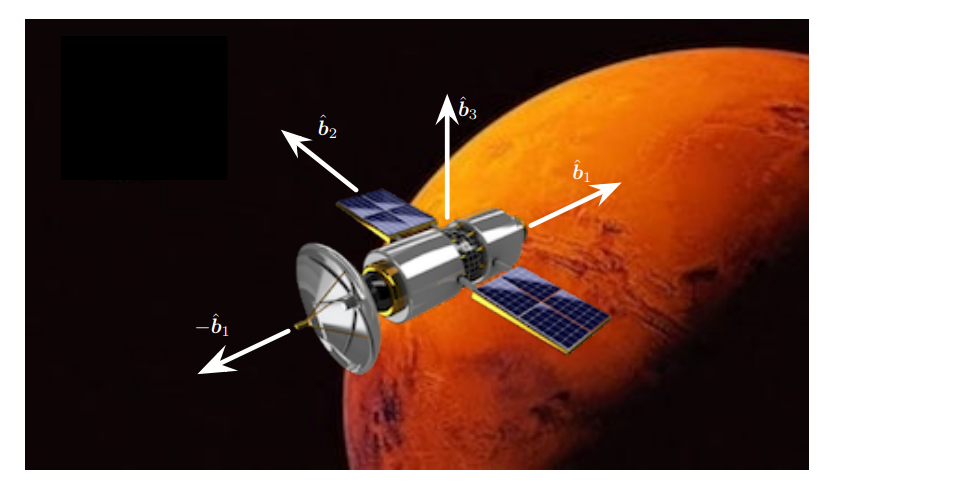

**Figure. 3.** Illustration of the spacecraft component directions.

To point the spacecraft sensor platform axis $\hat{b}_1$ towards the center of Mars or nadir direction, the reference frame $R_n$ must be chosen such that $\hat{r}_1$  axis points towards the planet. Further, assume the second axis $\hat{r}_2$  points in the velocity direction $\hat{i}_\theta$ . Your tasks are:

**4.1.** Determine an analytic expressions for the nadir pointing reference frame $R_n$ by defining the DCM $[RnN]$.

$$[RnN] = [HR_n]^T[H_sN]$$

$[H_sN]$ has already been established in task 2, its now just a matter of finding the transpose of $[HR_n]$ which maps the hill frame $H$ to the reference frame $R_n$.

$$\{\hat{i}\} = [HR_n]\{\hat{r}_n\}$$

$$ \hat{i}_{r} = \{\hat{r}_n\}[cos(\pi), cos(\frac{\pi}{2}), cos(\frac{\pi}{2})] = \{\hat{n}\}[-1, 0, 0] = -\hat{r}_{n_1} $$

$$ \hat{i}_{\theta} = \{\hat{r}_n\}[cos(\frac{\pi}{2}), cos(0), cos(\frac{\pi}{2})] = \{\hat{n}\}[ 0, 1, 0] = \hat{r}_{n_2} $$

$$ \hat{i}_{h} = \{\hat{r}_n\}[cos(\frac{\pi}{2}), cos(\frac{\pi}{2}),cos(\pi) ] = \{\hat{n}\}[ 0, 0, -1] = -\hat{r}_{n_3}$$

Therefore:
$$\{\hat{i}\} =  \left[\begin{array}{cc} 
-1 & 0 & 0 \\
0 & 1 & 0  \\
0 & 0 & -1  
\end{array}\right] \{\hat{r}_n\}$$

and:

$$[RnN] = \left[\begin{array}{cc} 
-1 & 0 & 0 \\
0 & 1 & 0  \\
0 & 0 & -1  
\end{array}\right][H_sN(t)]$$

**4.2.** Write a function that returns $[R_nN]$ as a function of time.

In [22]:
def R_nN(t):
    HR_n = np.array([[-1., 0.,  0.],
                     [ 0., 1.,  0.],
                     [ 0., 0., -1.]])
    
    return np.dot(HR_n.T, HN(t))              

**4.3.** Validate the evaluation of $[R_nN]$ by providing the numerical values for t = 330s.

In [23]:
print("Numerical values for [R_nN] at t = 330s.")
print(R_nN(330))

Numerical values for [R_nN] at t = 330s.
[[0.0725817393657607 -0.870577539663851 -0.486648372588953]
 [-0.982592207632705 -0.146079403212648 0.114775265003064]
 [-0.171010071662834 0.469846310392954 -0.866025403784439]]


**4.4.** Write a function that determines the angular velocity vector ${}^N\omega_{R_n/N}$.

In [24]:
"""
To obtain the inertial angular velocity of the reference frame w_Rn/N_Nframe, we need to map the Hill frame
angular velocity w_H/N_Hframe = sqrt(mu_Mars/R_LMO**3) to the inertial frame angular velocity w_H/N_Nframe 
using the [HN] DCM.

Therefore w_Rn/N_Nframe = [HN(t)]w_H/N_Hframe.

"""

def w_R_nN(t):
    w_HN_Hframe = dLMO_angles
    return np.dot(HN(t).T,  w_HN_Hframe)

**4.5.** What is the angular velocity ${}^N\omega_{R_n/N}$ at t = 330s?

In [25]:
print("w_Rn/N_Nframe evaluated at 330s.")
print(w_R_nN(330))

w_Rn/N_Nframe evaluated at 330s.
[0.000151309151480406 -0.000415718477049255 0.000766256441699265]


### TASK 5: GMO-Pointing Reference Frame Orientation.

To point the nano-satellite communication platform axis $\hat{b}_1$  towards the GMO mother spacecraft, the communication reference frame $R_c$ must be chosen such that $-\hat{r}_1$ axis points towards the GMO satellite location. Assume $\Delta r = r_{GMO} − r_{LMO}.$ Further, to fully define a three-dimensional reference frame, assume the second axis is defined as:

$$\hat{r}_2 = \frac{\Delta r \times \hat{n}_3}{|\Delta r \times \hat{n}_3|}$$

while the third is then defined as $\hat{r}_3 = \hat{r}_1 \times \hat{r}_2$. Your tasks are:

**5.1.** Determine an analytic expressions for the communication mode reference frame $R_c$ by defining the DCM $[R_cN]$.

The $[R_cN]$ DCM takes the vectrix form:

$$[R_cN] = \left[\begin{array}{cc} 
\hat{r}_1 \\
\hat{r}_2  \\
\hat{r}_3  
\end{array}\right]$$

Where: 
$$\hat{r}_1 = -\frac{\Delta r}{|\Delta r|}$$

$$\hat{r}_2 = \frac{\Delta r \times \hat{n}_3}{|\Delta r \times \hat{n}_3|}$$ 

$$\hat{r}_3 = \hat{r}_1 \times \hat{r}_2$$

**5.2.** Write a function that returns $[R_cN]$ as a function of time.

In [26]:
def R_cN(t):
    
    #Computing N_r_LMO, N_r_dot_LMO (LMO inertial position & velocity vector):
    N_r_LMO, N_r_dot_LMO = Inertial_Position_Velocity_Vec(LMO_angles, dLMO_angles, R_LMO, t)
    
    #Computing N_r_GMO, N_r_dot_GMO (GMO inertial position & velocity vector):
    N_r_GMO, N_r_dot_GMO = Inertial_Position_Velocity_Vec(GMO_angles, dGMO_angles, R_GMO, t)
    
    #Computing delta r:
    Delta_r = N_r_GMO - N_r_LMO
    
    #Computing the vector norm of Delta_r:
    Delta_r_norm = sqrt(Delta_r[0]**2 + Delta_r[1]**2 + Delta_r[2]**2)
    
    #Computing the vector norm of Delta_r x n_3:
    Deltar_n3_cross = np.cross(Delta_r, np.array([0,0,1]))
    Deltar_n3_norm = sqrt(Deltar_n3_cross[0]**2 + Deltar_n3_cross[1]**2 + Deltar_n3_cross[2]**2)
    
    #Vectrix components:
    r1 = -Delta_r/Delta_r_norm
    r2 = Deltar_n3_cross/Deltar_n3_norm 
    r3 = np.cross(r1, r2)
    
    return np.array([r1, r2, r3])

**5.3.** Validate the evaluation of $[R_cN]$ by providing the numerical values for t = 330s.

In [27]:
print("[R_cN] evaluated at t = 330s.")
print(R_cN(330))

[R_cN] evaluated at t = 330s.
[[0.265475386427518 0.960928163081990 0.0783574157118102]
 [-0.963891811444147 0.266294152829010 0]
 [-0.0208661216348470 -0.0755280713705388 0.996925330906466]]


**5.3.** Write a function that determines the angular velocity vector ${}^N\omega_{R_c/N}$. Note that an analytical expression for this body rate vector is very challenging. It is ok to use numerical differences in these frames to compute $\frac{d}{dt}([RcN])$, and then relate this to $\omega_{R_c/N}$. As the orbit trajectories are given as a function of time, it is straight forward to include a time-based numerical difference method.

In [28]:
def N_w_RcN(t, h = 0.01):
    
    #Using Newtons difference quotient to numerically differentiate: 
    d_dt_RcN = (R_cN(t + h) - R_cN(t))/h
    
    #Using d/dt[R_cN] = -[w_tilde][R_cN] -> [w_tilde] = -[R_cN]^T d/dt[R_cN]:
    w_tilde = np.dot(-R_cN(t).T, d_dt_RcN)
    
    w1 = -w_tilde[1][2]; w2 = w_tilde[0][2]; w3 = -w_tilde[0][1]
    
    return np.array([w1, w2, w3])

**5.4.** Validate the angular velocity ${}^N\omega_{R_c/N}$ at t = 330s.

In [29]:
print("N_w_RcN evaluated at t = 330s.")
print(N_w_RcN(330))

N_w_RcN evaluated at t = 330s.
[1.97826625592675e-5 -5.46535130226860e-6 0.000191299928353177]


### TASK 6: Attitude Error Evaluation.

Any attitude feedback control algorithm requires the ability to compute the attitude and angular velocity tracking errors of the current body frame $B$ relative to the reference frame $R$. Your tasks are:

**6.1.** Write a function that has the inputs of time, the current body attitude states $\sigma_{B/N}$ and ${}^B\omega_{B/N}$ , as well as the current references frame frame orientation $[RN]$ and rates ${}^N\omega_{R/N}$ , and returns the associated tracking errors $\sigma_{B/R}$ and ${}^B\omega_{B/R}$.

In [887]:
"""
The tracking error function computes the discrepancies of the following:

1) Attitude Error (Sigma_BR): Discrepancy Between the body frame attitude descriptions 
   by computing the differnce between the attitude description of the body frame 
   relative to the inertial frame with the attitude description of the reference frame
   relative to the inertial utilising DCM subtraction properties.

2) Angular Velocity Error (Omega_BR): Discrepency between the  body frame angular velocity descriptions 
   by computing the differnce between the angular velocity description of the body frame 
   relative to the inertial frame with the angular velocity description of the reference frame
   relative to the inertial.
"""

def Tracking_Errors_BR(Sigma_BN, B_Omega_BN, RN, N_Omega_RN, t):

    #Attitude description error Sigma_BR in the MRP coordinate set:
    Sigma_BR = DCM_to_MRP(np.dot(MRP_to_DCM(Sigma_BN), RN.T))
    
    #MRP shadow set condition:
    if np.dot(Sigma_BR, Sigma_BR) > 1:
        Sigma_BR = MRP_Shadow(Sigma_BR)
        
    #Angular Velocity description error Omega_BR:
    B_Omega_RN = np.dot(MRP_to_DCM(Sigma_BN), N_Omega_RN)
    Omega_BR = B_Omega_BN - B_Omega_RN
        
    return Sigma_BR, Omega_BR

**6.2.** Validate this function by computing $\sigma_{B/R}$ and ${}^B\omega_{B/R}$ at the initial time $t_0$ for the sun-pointing, nadir pointing and GMO reference orientations above. Just compute the LMO tracking errors at $t_0$, with the initial conditions given in section 3.1, for the three reference frames at the initial time.

**6.2.1.** Sun-Pointing Reference Frame Orientation $\sigma_{B/R}$ and ${}^B\omega_{B/R}$ at $t_0$:

In [31]:
print("Sigma_BR at t_0:")
print(Tracking_Errors_BR(Sigma_BN, Omega_BN, R_sN(), np.array([0, 0, 0]), 0)[0], "\n")

print("Omega_BR at t_0:")
print(Tracking_Errors_BR(Sigma_BN, Omega_BN, R_sN(), np.array([0, 0, 0]), 0)[1])

Sigma_BR at t_0:
[-0.775420766459049 -0.473868246169419 0.0430789314699472] 

Omega_BR at t_0:
[ 0.01745329  0.03054326 -0.03839724]


**6.2.2.** Nadir-Pointing Reference Frame Orientation $\sigma_{B/R}$ and ${}^B\omega_{B/R}$ at $t_0$:

In [32]:
print("Sigma_BR at t_0:")
print(Tracking_Errors_BR(Sigma_BN, Omega_BN, R_nN(0), w_R_nN(0), 0)[0], "\n")

print("Omega_BR at t_0:")
print(Tracking_Errors_BR(Sigma_BN, Omega_BN, R_nN(0), w_R_nN(0), 0)[1])

Sigma_BR at t_0:
[0.262265229607561 0.554704565767729 0.0394240509829659] 

Omega_BR at t_0:
[0.0168488322007025 0.0309287884407398 -0.0389157628418865]


**6.2.3.** GMO-Pointing Reference Frame Orientation $\sigma_{B/R}$ and ${}^B\omega_{B/R}$ at $t_0$:

In [33]:
print("Sigma_BR at t_0:")
print(Tracking_Errors_BR(Sigma_BN, Omega_BN, R_cN(0), N_w_RcN(0), 0)[0], "\n")

print("Omega_BR at t_0:")
print(Tracking_Errors_BR(Sigma_BN, Omega_BN, R_cN(0), N_w_RcN(0), 0)[1])

Sigma_BR at t_0:
[0.0169719805586837 -0.382802752844420 0.207613099166360] 

Omega_BR at t_0:
[0.0172970886801705 0.0306574426735848 -0.0384368697899326]


### TASK 7: Numerical Attitude Simulator.

In order to integrate the attitude you need a numerical integrator. The LMO and GMO orbit satellite
positions are given already as a function of time from your earlier tasks. Let the propagated attitude state $X$ be:

$$X = \left[\begin{array}{cc} 
\sigma_{B/N} \\
{}^B\omega_{B/N} \\
\end{array}\right]$$

Assume that the spacecraft is rigid and its dynamics obey:

$$[I]\dot{\omega}_{B/N} = -[\tilde{\omega}_{B/N}][I]\omega_{B/N} + u$$

where $u$ is your external control torque vector: 

$${}^Bu = -K\sigma_{B/R} - P{}^B\omega_{B/R}$$

In [12]:
def Control_Torque(t, Sigma_BN, Omega_BN, case=0):
    
   
    if case == 0:   #Task 7: requires u = 0.
        u = np.array([0, 0, 0])
    
    elif case == 1: #Task 7: Also requires a fixed control torque.
        u = np.array([0.01, -0.01, 0.02])
        
    elif case == 2: #Task 8: Sun-Pointing control.
        E_BR = Tracking_Errors_BR(Sigma_BN, Omega_BN, R_sN(), np.array([0, 0, 0]), t)
        u = - K[0][0]*E_BR[0] - P[0][0]*E_BR[1]
    
    elif case == 3: #Task 9: Nadir-Pointing control.
        E_BR = Tracking_Errors_BR(Sigma_BN, Omega_BN, R_nN(t), w_R_nN(t), t)
        u = - K[0][0]*E_BR[0] - P[0][0]*E_BR[1]
        
    elif case == 4: #Task 10: GMO-Pointing control.
        E_BR = Tracking_Errors_BR(Sigma_BN, Omega_BN, R_cN(t), N_w_RcN(t), t)
        u = - K[0][0]*E_BR[0] - P[0][0]*E_BR[1]
    
    return u
    
"""
Returns Omega_BN_dot from Euler's rotational EOM.

"""    
def Control_EOM(w, u, L = np.zeros(3)):
    return np.dot(np.linalg.inv(I), (-np.cross(w, np.dot(I, w)) + u + L))

In [13]:
"""
First order MRP kinematic equation. Returns Sigma_BN_dot.
"""
def MRP_Kinematic_Eq(Sigma, w):
    
    q_1, q_2, q_3 = Sigma
    
    norm = (np.dot(Sigma,Sigma)/sqrt(np.dot(Sigma,Sigma)))
    
    Q = np.array([[1 - norm**2 + 2 * q_1**2, 2 * (q_1 * q_2 - q_3), 2 * (q_1 * q_3 + q_2)],
                  [2 * (q_1 * q_2 + q_3), 1 - norm**2 + 2 * q_2**2, 2 * (q_2 * q_3 - q_1)],
                  [2 * (q_1 * q_3 - q_2), 2 * (q_2 * q_3 + q_1), 1 - norm**2 + 2 * q_3**2]] , dtype = np.float64)
    
    dQdt = np.dot(Q, w) * 1/4
    
    return dQdt

In [14]:
"""
The state vector/vectrix constructed of the derivatives of the MRP attitudes and angular velocities.

"""
def State_vec_dot(t, State_vec, case = 0):
    #Slicng the 1x6 concatenated list of sigma and omega from the state vector:
    #Sig_BN = State_vec[:3]
    #w_BN = State_vec[3:]
    
    #MRP shadow set condition.
    if np.dot(State_vec[:3], State_vec[:3]) > 1:
        State_vec[:3] = MRP_Shadow(State_vec[:3])
        
 
    #Sigma_BN_dot from MRP differential eqs:
    Sig_BN_dot = MRP_Kinematic_Eq(State_vec[:3], State_vec[3:])
    #Omega_BN_dot from Eulers EOM:
    w_BN_dot = Control_EOM(State_vec[3:], Control_Torque(t, State_vec[:3], State_vec[3:], case))

    
    #State vector derivative:
    Xdot = np.array([Sig_BN_dot, w_BN_dot])
    
    return Xdot.flatten(order='C')
    

**7.1.** Write an RK4 integrator using your programing language of choice (i.e., do not use a built-inintegrator such as Matlab’s ode45). Make sure your time step is chosen small enough such that numerical integrator errors are not visible in your simulation result plots. With RK4 it is ok to use a fixed integration time step of 1 second. Further, hold the control $u$ vector piece-wise constant over the RK4 integration to the next time step. You can updated the control $u$ at every time step
in advance fo the RK4 integration step.

In [15]:
def RK4(f, x0, t, dt):
    # Storing t and state vector values.
    t_plot = []
    x_plot = np.zeros((N-1,6))
    
    
    for i in range(0, N-1):
        
        #RK4 algorithm.
        f1 = f(t, x0)
        f2 = f(t + (dt / 2), x0 + (dt/2) * f1)
        f3 = f(t + (dt / 2), x0 + (dt / 2) * f2)
        f4 = f(t + dt, x0 + dt * f3)
        
        #Updating state vector values.
        x0 = x0 + (dt/6) * (f1 + 2 * f2 + 2 * f3 + f4)
        
        #Moving up the timestep by increment dt.
        t = t + dt
   
        x_plot[i] = x0; t_plot.append(t)
        
    return x_plot, t_plot

**7.2.** Demonstrate that your integrator works properly by integrating $X$ forward for 500 seconds with $u = 0$. Provide $H = [I]\omega_{B/N}$ at 500 seconds and express the $H$ vector in the $B$ frame.

In [69]:
#Time vector over 500s
dt = 0.001
T = 501
N = int(T/dt)

#Initial conditions:
x0 = np.concatenate((Sigma_BN, Omega_BN))
t = 0

f = lambda t, State_vec: State_vec_dot(t, State_vec)

Solution_BN = RK4(f, x0, t, dt)

In [70]:
#Sigma_BN and Omega_BN solution set for 500s.
Sigma_BN_plot = Solution_BN[0][:,:3]
Omega_BN_plot = Solution_BN[0][:,3:]

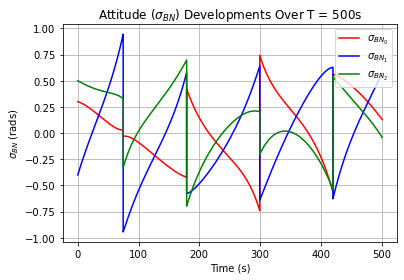

In [71]:
plt.plot(Solution_BN[1], Sigma_BN_plot[:,0], 'r', label = "$\sigma_{BN_0}$")
plt.plot(Solution_BN[1], Sigma_BN_plot[:,1], 'b', label = "$\sigma_{BN_1}$")
plt.plot(Solution_BN[1], Sigma_BN_plot[:,2], 'g', label = "$\sigma_{BN_2}$")

plt.legend(loc='upper right')
plt.title('Attitude ($\sigma_{BN}$) Developments Over T = 500s')
plt.xlabel("Time (s)")
plt.ylabel("$\sigma_{BN}$ (rads)")
plt.grid(true)

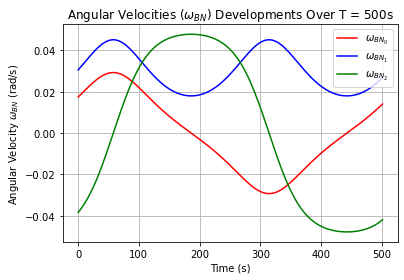

In [72]:
plt.plot(Solution_BN[1], Omega_BN_plot[:,0], 'r', label = "$\omega_{BN_0}$")
plt.plot(Solution_BN[1], Omega_BN_plot[:,1], 'b', label = "$\omega_{BN_1}$")
plt.plot(Solution_BN[1], Omega_BN_plot[:,2], 'g', label = "$\omega_{BN_2}$")

plt.legend(loc='upper right')
plt.title("Angular Velocities ($\omega_{BN}$) Developments Over T = 500s")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity $\omega_{BN}$ (rad/s)")
plt.grid(true)

Providing $H = [I]\omega_{B/N}$ at 500 seconds and express the $H$ vector in the $B$ frame:

In [83]:
H_B = np.dot(I, Omega_BN_plot[500000])
print("H_B at t = 500s:")
print(H_B)

H_B at t = 500s:
[ 0.1379      0.13266351 -0.31638598]


**7.3.**  Provide the rotational kinetic energy $T = \frac{1}{2}\omega_{B/N}^T[I]\omega_{B/N}$ at 500 seconds.

In [1019]:
T = 0.5 * np.dot(Omega_BN_plot[-1].T, np.dot(I, Omega_BN_plot[-1]))
print("T at t = 500s:")
print(T)

T at t = 500s:
0.00938412038830436


**7.4.** Provide the attitude $\sigma_{B/N}$ at 500 seconds.

In [80]:
print("Sigma_BN at t = 500s:")
print(Sigma_BN_plot[500000])

Sigma_BN at t = 500s:
[ 0.12978355  0.57249354 -0.04160835]


**7.5.** Provide the Provide angular momentum vector ${}^NH$ at t = 500s in inertial frame components.

In [84]:
H_N = np.dot(MRP_to_DCM(Sigma_BN_plot[500000]).T, H_B)
print("H_N expressed in the inertial frame:")
print(H_N)

H_N expressed in the inertial frame:
[-0.264125028784882 0.252777374853148 0.0552962354031251]


**7.6.** If you apply a fixed control torque ${}^Bu = (0.01, -0.01, 0.02)Nm$. Provide the attitude $\sigma_{B/N}$ at t = 100s.

In [613]:
#Time vector over 100s, Ensure case = 1.
dt = 0.001
T = 100
N = int(T/dt)

#Initial conditions:
x0 = np.concatenate((Sigma_BN, Omega_BN))
t = 0

f_case1 = lambda t, State_vec: State_vec_dot(t, State_vec)

Solution_BN_case1 = RK4(f_case1, x0, t, dt)

In [617]:
#Sigma_BN and Omega_BN solution set for 100s with fixed torque "u".
Sigma_BN_plot_case1 = Solution_BN_case1[0][:,:3]
Omega_BN_plot_case1 = Solution_BN_case1[0][:,3:]

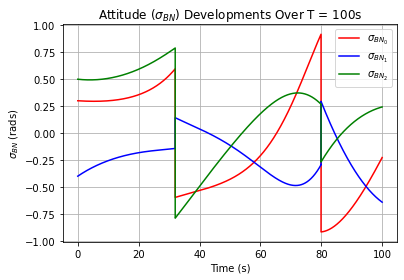

In [618]:
plt.plot(Solution_BN_case1[1], Sigma_BN_plot_case1[:,0], 'r', label = "$\sigma_{BN_0}$")
plt.plot(Solution_BN_case1[1], Sigma_BN_plot_case1[:,1], 'b', label = "$\sigma_{BN_1}$")
plt.plot(Solution_BN_case1[1], Sigma_BN_plot_case1[:,2], 'g', label = "$\sigma_{BN_2}$")

plt.legend(loc='upper right')
plt.title('Attitude ($\sigma_{BN}$) Developments Over T = 100s')
plt.xlabel("Time (s)")
plt.ylabel("$\sigma_{BN}$ (rads)")
plt.grid(true)

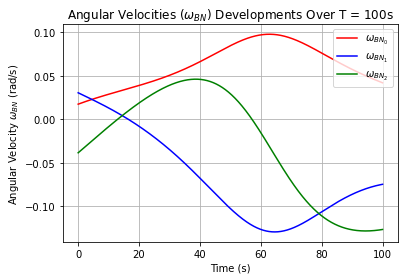

In [619]:
plt.plot(Solution_BN_case1[1], Omega_BN_plot_case1[:,0], 'r', label = "$\omega_{BN_0}$")
plt.plot(Solution_BN_case1[1], Omega_BN_plot_case1[:,1], 'b', label = "$\omega_{BN_1}$")
plt.plot(Solution_BN_case1[1], Omega_BN_plot_case1[:,2], 'g', label = "$\omega_{BN_2}$")

plt.legend(loc='upper right')
plt.title("Angular Velocities ($\omega_{BN}$) Developments Over T = 100s")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity $\omega_{BN}$ (rad/s)")
plt.grid(true)

In [620]:
print("Sigma_BN at t = 100s:")
print(Sigma_BN_plot_case1[-1])

Sigma_BN at t = 100s:
[-0.22701703 -0.64138408  0.24248702]


### TASK 8: Sun-Pointing Control.

First the individual control pointing modes are developed and tested on their own. Next they are combined into a full mission scenario simulation in section 11. In the current task, use the initial spacecraft attitude and orbit conditions in section 3.1. Assume the spacecraft is to engage directly into a sun-pointing mode starting at $t0$. The attitude control law is the simple PD control:

$${}^Bu = -K\sigma_{B/R} - P{}^B\omega_{B/R}$$ 

Your tasks are:

**8.1.** Use linearized closed loop dynamics of a regular problem, such as this sun pointing control, to
determine the $K$ and $P$ feedback gains such that the slowest decay response time (i.e. time for
tracking errors to be $\frac{1}{e}$ the original size) is 120 seconds. This means all decay time constants
should be 120 seconds or less. Further, the closed loop response for all $\sigma_{B/N}$ components
should be either critically damped or under-damped. Thus at least must be critically damped with
$ξ = 1$, while the other modes will have $ξ ≤ 1$.

Under the assumption that both $[I]$ anf $[P]$ are are diagonal matrices, one notes that:
$$\xi_i = \frac{P_i}{\sqrt{KI_i}}$$ 

Which corresponds to the underdamped damping ratios.

$$T_i = \frac{2 I_i}{P_i}$$

Which Corresponds to the time taked for the state errors to decay to $\frac{1}{e}$ times their initial value.

In [657]:
def Control_Gain(T = 120):
    
    P_max = [max(map(max, 2 * I * 1/T))] * np.eye(3)
    K_max = [max(i**2/j for i in (2 * I * 1/T).diagonal() for j in I.diagonal())] * np.eye(3)

    return P_max, K_max

In [1002]:
P = Control_Gain()[0]
K = Control_Gain()[1]

In [820]:
print("Feedback Control Gains:")
print("P:")
print(P)
print("K:")
print(K)

Feedback Control Gains:
P:
[[0.16666667 0.         0.        ]
 [0.         0.16666667 0.        ]
 [0.         0.         0.16666667]]
K:
[[0.00555556 0.         0.        ]
 [0.         0.00555556 0.        ]
 [0.         0.         0.00555556]]


**8.2.** Numerically implement this control law in your earlier simulation and ensure that sun-pointing is
achieved with the desired closed loop performance.

In [1003]:
#Time vector over 400s, Ensure case = 2.
dt = 0.1
T = 400
N = int(T/dt)

#Initial conditions:
x0_c2 = np.concatenate((Sigma_BN, Omega_BN))
t = 0

f_case2 = lambda t, State_vec_c2: State_vec_dot(t, State_vec_c2, case=2)

Solution_case2 = RK4(f_case2, x0_c2, t, dt)

In [1004]:
#Sigma_BN and Omega_BN solution set for 400s.
Sigma_plot_case2 = Solution_case2[0][:,:3]
Omega_plot_case2 = Solution_case2[0][:,3:]

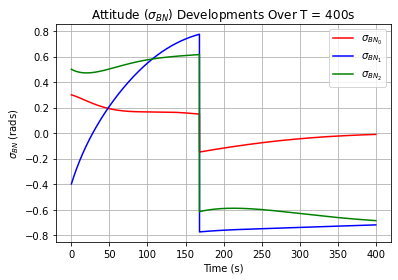

In [1008]:
plt.plot(Solution_case2[1], Sigma_plot_case2[:,0], 'r', label = "$\sigma_{BN_0}$")
plt.plot(Solution_case2[1], Sigma_plot_case2[:,1], 'b', label = "$\sigma_{BN_1}$")
plt.plot(Solution_case2[1], Sigma_plot_case2[:,2], 'g', label = "$\sigma_{BN_2}$")

plt.legend(loc='upper right')
plt.title('Attitude ($\sigma_{BN}$) Developments Over T = 400s')
plt.xlabel("Time (s)")
plt.ylabel("$\sigma_{BN}$ (rads)")
plt.grid(true)

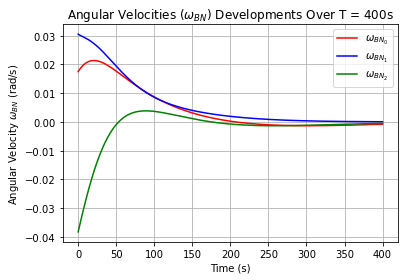

In [1009]:
plt.plot(Solution_case2[1], Omega_plot_case2[:,0], 'r', label = "$\omega_{BN_0}$")
plt.plot(Solution_case2[1], Omega_plot_case2[:,1], 'b', label = "$\omega_{BN_1}$")
plt.plot(Solution_case2[1], Omega_plot_case2[:,2], 'g', label = "$\omega_{BN_2}$")

plt.legend(loc='upper right')
plt.title("Angular Velocities ($\omega_{BN}$) Developments Over T = 400s")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity $\omega_{BN}$ (rad/s)")
plt.grid(true)

**8.3.** Validate the response by providing the $\sigma_{B/N}$ states at t = 15s, 100s, 200s and 400s. Note that
you must always provide the MRP corresponding to the short rotation.

In [1077]:
time = [150, 1000, 2000, len(Sigma_plot_case2)-1]
for i in time:
    print("Sigma_BN at time: ", i*dt, "s.")
    print(Sigma_plot_case2[i], "\n")

Sigma_BN at time:  15.0 s.
[ 0.26519737 -0.15839244  0.47288046] 

Sigma_BN at time:  100.0 s.
[0.16626615 0.54881503 0.57436838] 

Sigma_BN at time:  200.0 s.
[-0.117113   -0.76072122 -0.59045799] 

Sigma_BN at time:  399.8 s.
[-0.01026468 -0.71900398 -0.68558397] 



### TASK 9: Nadir-Pointing Control.

Next the nadir pointing attitude mode is created and tested. Use the same gains $K$ and $P$ as developed
for sun-pointing, and the PD control. Your tasks are:


**9.1.** Numerically implement the nadir pointing control mode and for now just assume that at $t_0$ nadir
pointing is required, even though the satellite is in the sunlight at this time.

In [1062]:
#Time vector over 400s, Ensure case = 3.
dt = 0.1
T = 400
N = int(T/dt)

#Initial conditions:
x0_c3 = np.concatenate((Sigma_BN, Omega_BN))
t = 0

f_case3 = lambda t, State_vec_c3: State_vec_dot(t, State_vec_c3, case=3)

Solution_case3 = RK4(f_case3, x0_c3, t, dt)

In [1063]:
#Sigma_BN and Omega_BN solution set for 400s.
Sigma_plot_case3 = Solution_case3[0][:,:3]
Omega_plot_case3 = Solution_case3[0][:,3:]

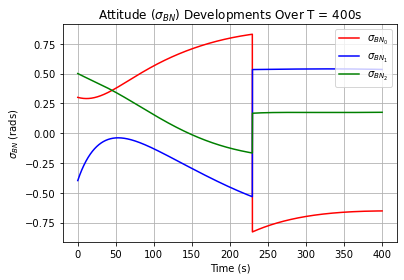

In [1064]:
plt.plot(Solution_case3[1], Sigma_plot_case3[:,0], 'r', label = "$\sigma_{BN_0}$")
plt.plot(Solution_case3[1], Sigma_plot_case3[:,1], 'b', label = "$\sigma_{BN_1}$")
plt.plot(Solution_case3[1], Sigma_plot_case3[:,2], 'g', label = "$\sigma_{BN_2}$")

plt.legend(loc='upper right')
plt.title('Attitude ($\sigma_{BN}$) Developments Over T = 400s')
plt.xlabel("Time (s)")
plt.ylabel("$\sigma_{BN}$ (rads)")
plt.grid(true)

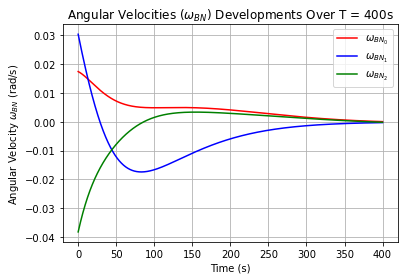

In [1065]:
plt.plot(Solution_case3[1], Omega_plot_case3[:,0], 'r', label = "$\omega_{BN_0}$")
plt.plot(Solution_case3[1], Omega_plot_case3[:,1], 'b', label = "$\omega_{BN_1}$")
plt.plot(Solution_case3[1], Omega_plot_case3[:,2], 'g', label = "$\omega_{BN_2}$")

plt.legend(loc='upper right')
plt.title("Angular Velocities ($\omega_{BN}$) Developments Over T = 400s")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity $\omega_{BN}$ (rad/s)")
plt.grid(true)

**9.2.** Validate the response by providing the $\sigma_{B/N}$ states at t = 15s, 100s, 200s and 400s. Note that
you must always provide the MRP corresponding to the short rotation.

In [1076]:
time = [150, 1000, 2000, len(Sigma_plot_case3)-1]
for i in time:
    print("Sigma_BN at time: ", i*dt, "s.")
    print(Sigma_plot_case3[i], "\n")

Sigma_BN at time:  15.0 s.
[ 0.29088118 -0.18979667  0.45316331] 

Sigma_BN at time:  100.0 s.
[ 0.56478851 -0.13180457  0.15366586] 

Sigma_BN at time:  200.0 s.
[ 0.79691529 -0.45425144 -0.12611132] 

Sigma_BN at time:  399.8 s.
[-0.65267884  0.5341673   0.1745772 ] 



### TASK 10: GMO-Pointing Control.

Next the GMO pointing attitude mode is created and test. Use the same gains $K$ and $P$ as developed
for sun-pointing, and the PD control. Your tasks are:

**10.1.** Numerically implement the GMO pointing control mode and for now just assume that at $t_0$ GMO
pointing is required, even though the satellite is in the sunlight at this time.

In [1085]:
#Time vector over 400s, Ensure case = 4.
dt = 0.1
T = 400
N = int(T/dt)

#Initial conditions:
x0_c4 = np.concatenate((Sigma_BN, Omega_BN))
t = 0

f_case4 = lambda t, State_vec_c4: State_vec_dot(t, State_vec_c4, case=4)

Solution_case4 = RK4(f_case4, x0_c4, t, dt)

In [1087]:
#Sigma_BN and Omega_BN solution set for 400s.
Sigma_plot_case4 = Solution_case4[0][:,:3]
Omega_plot_case4 = Solution_case4[0][:,3:]

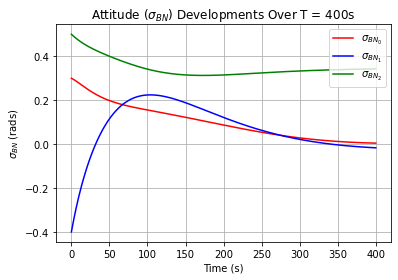

In [1088]:
plt.plot(Solution_case4[1], Sigma_plot_case4[:,0], 'r', label = "$\sigma_{BN_0}$")
plt.plot(Solution_case4[1], Sigma_plot_case4[:,1], 'b', label = "$\sigma_{BN_1}$")
plt.plot(Solution_case4[1], Sigma_plot_case4[:,2], 'g', label = "$\sigma_{BN_2}$")

plt.legend(loc='upper right')
plt.title('Attitude ($\sigma_{BN}$) Developments Over T = 400s')
plt.xlabel("Time (s)")
plt.ylabel("$\sigma_{BN}$ (rads)")
plt.grid(true)

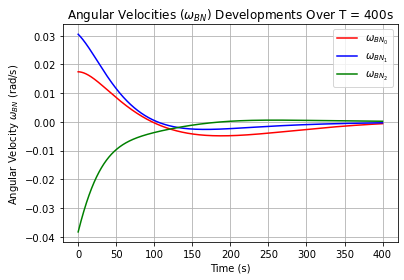

In [1089]:
plt.plot(Solution_case4[1], Omega_plot_case4[:,0], 'r', label = "$\omega_{BN_0}$")
plt.plot(Solution_case4[1], Omega_plot_case4[:,1], 'b', label = "$\omega_{BN_1}$")
plt.plot(Solution_case4[1], Omega_plot_case4[:,2], 'g', label = "$\omega_{BN_2}$")

plt.legend(loc='upper right')
plt.title("Angular Velocities ($\omega_{BN}$) Developments Over T = 400s")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity $\omega_{BN}$ (rad/s)")
plt.grid(true)

**10.2.** Validate the response by providing the $\sigma_{B/N}$ states at t = 15s, 100s, 200s and 400s. Note that
you must always provide the MRP corresponding to the short rotation.

In [1078]:
time = [150, 1000, 2000, len(Sigma_plot_case4)-1]
for i in time:
    print("Sigma_BN at time: ", i*dt, "s.")
    print(Sigma_plot_case4[i], "\n")

Sigma_BN at time:  15.0 s.
[ 0.26524739 -0.16741827  0.45902575] 

Sigma_BN at time:  100.0 s.
[0.15559417 0.22397664 0.3411023 ] 

Sigma_BN at time:  200.0 s.
[0.08732058 0.12155607 0.31476503] 

Sigma_BN at time:  399.8 s.
[ 0.00508508 -0.0161339   0.34239787] 



### TASK 11: Mission Scenario Simulation.

Finally you are ready to simulate the full on mission scenario. Use the initial spacecraft attitude and orbit
conditions in section 3, then propagate 6500 seconds to demonstrate how the attitude
pointing performance of the nano-satellite as it enters different control modes. Your tasks are:

**11.1.** Numerically implement a login into your above simulation such that the satellite automatically
computer the proper reference frame stages as it switches between sun-pointing, nadir-pointing
and communication modes

In [1130]:
def Auto_Frame_Switch(t0, x0, tf, dt):
    
    """
    R > 0: - Sun-Pointing position. (i.e satellite is in the +n_2 plane). (Power Mode)
    
    R < 0: - GMO-Pointing position for ±35 deg window between satellite and mothership. (Communication Mode)
           
           - Nadir-Pointing position otherwise. (Science Mode)   
    """
    
    
    t = np.arange(t0, tf, dt)
    nt = t.size
    
    # Constructing final vector
    nx = x0.size
    x = np.zeros((nx, nt))
    
    # Initial conditions
    x[:,0] = x0 
    
    for i in range(nt-1):
        
        R = Inertial_Position_Velocity_Vec(LMO_angles, dLMO_angles, R_LMO, i)
        R_GMO_N = Inertial_Position_Velocity_Vec(GMO_angles, dGMO_angles, R_GMO, i)

        while R[0][1] > 0:
            
            """Sun-Pointing Position (Power Mode)"""
            f = lambda t, State_vec: State_vec_dot(t, State_vec, case=2)
        
            f1 = f(t[i], x[:, i])
            f2 = f(t[i] + dt/2, x[:, i] + f1/2)
            f3 = f(t[i] + dt/2, x[:, i] + f2/2)
            f4 = f(t[i] + dt, x[:, i] + f3)
        
            # k_ns are used to calculate dx
            dx = (dt/6) * (f1 + 2 * f2 + 2 * f3 + f4)
        
            #dx is used to calculate x at the next time step
            x[:, i+1] = x[:, i] + dx
            
            break
            
        else:
            
            Comms_Angle = np.rad2deg(np.arccos(np.dot(R[0],R_GMO_N[0])/(np.linalg.norm(R[0])*np.linalg.norm(R_GMO_N[0]))))
            
            if -35 < Comms_Angle < 35:
                
                """GMO-Pointing Position (Communication Mode)"""
                f = lambda t, State_vec: State_vec_dot(t, State_vec, case=4)
            
                f1 = f(t[i], x[:, i])
                f2 = f(t[i] + dt/2, x[:, i] + f1/2)
                f3 = f(t[i] + dt/2, x[:, i] + f2/2)
                f4 = f(t[i] + dt, x[:, i] + f3)
        
                # k_ns are used to calculate dx
                dx = (dt/6) * (f1 + 2 * f2 + 2 * f3 + f4)
        
                #dx is used to calculate x at the next time step
                x[:, i+1] = x[:, i] + dx
                
            
            else:
                
                """Nadir-Pointing Position (Science Mode)"""
                f = lambda t, State_vec: State_vec_dot(t, State_vec, case=3)
            
                f1 = f(t[i], x[:, i])
                f2 = f(t[i] + dt/2, x[:, i] + f1/2)
                f3 = f(t[i] + dt/2, x[:, i] + f2/2)
                f4 = f(t[i] + dt, x[:, i] + f3)
        
                # k_ns are used to calculate dx
                dx = (dt/6) * (f1 + 2 * f2 + 2 * f3 + f4)
        
                #dx is used to calculate x at the next time step
                x[:, i+1] = x[:, i] + dx
            
         
    return x, t
          

In [1133]:
Position_Vel, Time = Auto_Frame_Switch(0, np.concatenate((Sigma_BN, Omega_BN)), 6500, 1)

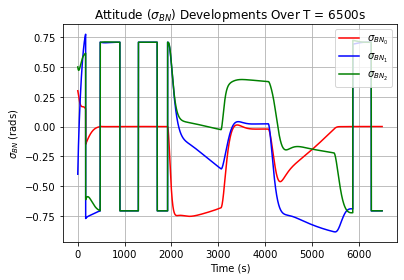

In [1134]:
plt.plot(Time, Position_Vel[0][:], 'r', label='$\sigma_{BN_0}$')
plt.plot(Time, Position_Vel[1][:], 'b', label='$\sigma_{BN_1}$')
plt.plot(Time, Position_Vel[2][:], 'g', label='$\sigma_{BN_2}$')

plt.legend(loc='upper right')
plt.title('Attitude ($\sigma_{BN}$) Developments Over T = 6500s')
plt.xlabel("Time (s)")
plt.ylabel('$\sigma_{BN}$ (rads)')
plt.grid(true)

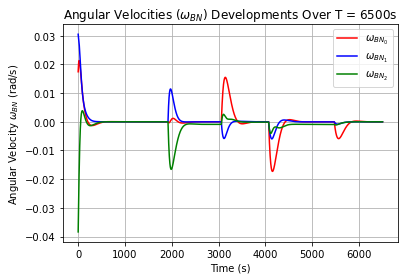

In [1135]:
plt.plot(Time, Position_Vel[3][:], 'r', label='$\omega_{BN_0}$')
plt.plot(Time, Position_Vel[4][:], 'b', label='$\omega_{BN_1}$')
plt.plot(Time, Position_Vel[5][:], 'g', label='$\omega_{BN_2}$')

plt.legend(loc='upper right')
plt.title("Angular Velocities ($\omega_{BN}$) Developments Over T = 6500s")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity $\omega_{BN}$ (rad/s)")
plt.grid(true)

**11.2.** Validate the response by providing the σB/N states at t = 300s, 2100s, 3400s, 4400s and 5600s.
Note that you must always provide the MRP corresponding to the short rotation.


In [1205]:
Sigma_BN_Mission = np.array([Position_Vel[0][:], Position_Vel[1][:], Position_Vel[2][:]])

Time = [300, 2100, 3400, 4400, 5600]

vals = [Sigma_BN_Mission[j][i] for i in Time for j in range(0,3)]

for i in range(0, len(Time)):
    print("Sigma_BN at t:", Time[i],"s")
    print(vals[3*i:3*(i+1)], "\n")

Sigma_BN at t: 300 s
[-0.044613606123869554, -0.7384206268561577, -0.6295943769746767] 

Sigma_BN at t: 2100 s
[-0.7455992991825158, 0.11603079499417894, 0.16004412348410718] 

Sigma_BN at t: 3400 s
[0.013101498918503577, 0.03962341958545865, 0.3905891634624314] 

Sigma_BN at t: 4400 s
[-0.43343429299780134, -0.7322269880449793, -0.1872036527832929] 

Sigma_BN at t: 5600 s
[-0.001076225390010191, -0.826519234570599, -0.5030827087238274] 

